In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

c:\Users\bshak\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\bshak\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\bshak\AppData\Local\Temp\ipykernel_102396\2853959488.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [56]:
def str_to_datetime(str_):
    split = str_.split("-")
    months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    return datetime.datetime(year=int(split[2]), month=int(months[split[1]]), day=int(split[0]))

df = pd.read_csv("DATA_PROJECT.csv").dropna()
df["Date"] = df["Date"].astype(str).apply(str_to_datetime)
df.index = df.pop("Date")
df["Australian dollar (AUD)"].head()

Date
2000-01-03    0.6583
2000-01-04    0.6583
2000-01-05    0.6558
2000-01-06    0.6582
2000-01-07    0.6539
Name: Australian dollar (AUD), dtype: float64

In [71]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, currency, n=30):
  #print(df[currency].dtypes)
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    #print(df_subset)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset.to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [88]:
models = []
predictions = []
dates_ = []
Xs = []
ys =[]

for column in df.columns:
    dn = df[column]
    windowed_df = df_to_windowed_df(dn, '5-Jan-2023', '1-Feb-2024',currency=column, n=30)
    #print(windowed_df.head())
    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    #print(dates)
    #print(X)
    print(y)

    q80 = int(len(dates) * .8)
    q90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q80], X[:q80], y[:q80]
    dates_val, X_val, y_val = dates[q80:q90], X[q80:q90], y[q80:q90]
    dates_test, X_test, y_test = dates[q90:], X[q90:], y[q90:]

    dates_.append([dates_train, dates_val, dates_test])
    Xs.append([X_train, X_val, X_test])
    ys.append([y_train, y_val, y_test])

    model = Sequential([layers.Input((30, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

    models.append(model)

    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()

    predictions.append([train_predictions, val_predictions, test_predictions])

float64
[0.6815 0.6769 0.6929 0.6904 0.6911 0.6923 0.6955 0.6973 0.6994 0.6904
 0.6918 0.6983 0.7033 0.7102 0.7102 0.7107 0.7092 0.7037 0.7068 0.715
 0.7062 0.6943 0.6931 0.6964 0.6954 0.6923 0.6908 0.6908 0.6937 0.6922
 0.6843 0.6896 0.6839 0.683  0.6814 0.6711 0.673  0.675  0.6746 0.6744
 0.6756 0.6713 0.6591 0.661  0.6599 0.6599 0.6649 0.6692 0.6637 0.6714
 0.6683 0.6691 0.6695 0.6741 0.6687 0.665  0.6689 0.6703 0.6687 0.6712
 0.6663 0.6765 0.6736 0.6694 0.6694 0.6694 0.6677 0.6671 0.6701 0.6783
 0.6715 0.6733 0.6727 0.6715 0.6708 0.6676 0.6676 0.6609 0.6627 0.661
 0.6639 0.6705 0.6664 0.669  0.6735 0.6775 0.6778 0.6764 0.6775 0.669
 0.6682 0.6674 0.6639 0.6647 0.6634 0.664  0.665  0.6598 0.6527 0.6515
 0.6509 0.6495 0.6511 0.6612 0.6607 0.6661 0.6678 0.6662 0.6662 0.6662
 0.6761 0.6767 0.6821 0.6888 0.6803 0.6783 0.6765 0.6697 0.6679 0.6712
 0.6646 0.6614 0.663  0.6688 0.6661 0.6635 0.6657 0.6682 0.6709 0.6808
 0.6889 0.6814 0.6821 0.6794 0.6828 0.6775 0.6736 0.6768 0.6763 0.6793
 

KeyboardInterrupt: 

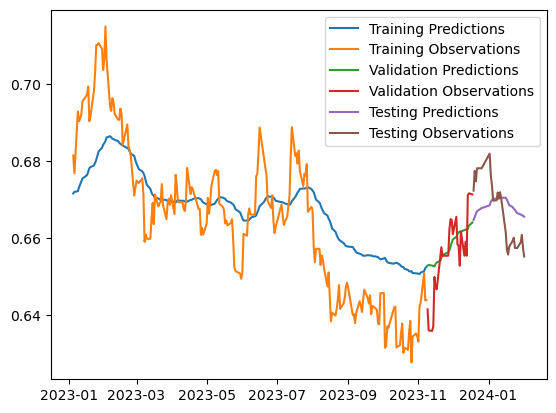

In [90]:
model_aud = models[0]

train_predictions, val_predictions, test_predictions = predictions[0]

dates_train, dates_val, dates_test = dates_[0]

#print(train_predictions)

y_train, y_val, y_test = ys[0]

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.show()